<a href="https://colab.research.google.com/github/cnn22/SingerSongwriter/blob/main/RNN_Emotions_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [6]:
#Read in data
train = pd.read_csv('train.txt', ';', header=None, names=['Sentence', 'Emotion'], index_col=False)
test = pd.read_csv('test.txt', ';', header=None, names=['Sentence', 'Emotion'], index_col=False)

In [4]:
test.Emotion.unique()

array(['sadness', 'joy', 'fear', 'anger', 'love', 'surprise'],
      dtype=object)

In [7]:
train.loc[train.Emotion == 'sadness', 'Emotion'] = 0
train.loc[train.Emotion == 'anger', 'Emotion'] = 1
train.loc[train.Emotion == 'love', 'Emotion'] = 2
train.loc[train.Emotion == 'surprise', 'Emotion'] = 3
train.loc[train.Emotion == 'fear', 'Emotion'] = 4
train.loc[train.Emotion == 'joy', 'Emotion'] = 5

In [8]:
test.loc[test.Emotion == 'sadness', 'Emotion'] = 0
test.loc[test.Emotion == 'anger', 'Emotion'] = 1
test.loc[test.Emotion == 'love', 'Emotion'] = 2
test.loc[test.Emotion == 'surprise', 'Emotion'] = 3
test.loc[test.Emotion == 'fear', 'Emotion'] = 4
test.loc[test.Emotion == 'joy', 'Emotion'] = 5

In [9]:
train.Emotion = train.Emotion.astype('int64')
test.Emotion = test.Emotion.astype('int64')

In [10]:
#converting pandas df into a 'TensorSliceDataset' type so we can use tensor flow objects...

train = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(train['Sentence'].values, tf.string),
            tf.cast(train['Emotion'].values, tf.int64)
        )
    )
)

test = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(test['Sentence'].values, tf.string),
            tf.cast(test['Emotion'].values, tf.int64)
        )
    )
)

In [11]:
#Shuffle the train and test data sets
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test = test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [10]:
for example, label in train.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'i have a feeling that its something ive missed because it shouldnt be that tedious'
 b'ive avoided thinking about it because i feel hurt just thinking it'
 b'ill admit that hes a pretty good designer but i feel like hes totally fake']

labels:  [0 0 0]


# Encode Text


In [12]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)

encoder.adapt(train.map(lambda text, label: text))

In [13]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'feel', 'and', 'to', 'the', 'a', 'that',
       'feeling', 'of', 'my', 'in', 'it', 'like', 'so', 'for', 'im', 'me',
       'but'], dtype='<U13')

# Creating the Model

In [23]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6) #this is the output layer, since we have 6 emotions we should have 6 as the output number instead of 1
])

In [14]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# Train the Model

In [15]:
history = model.fit(train, epochs=10,
                    validation_data=test,
                    validation_steps=30)

Epoch 1/10
250/250 [==============================] - 34s 108ms/step - loss: 1.6728 - accuracy: 0.3290 - val_loss: 1.5680 - val_accuracy: 0.3604
Epoch 2/10
250/250 [==============================] - 25s 100ms/step - loss: 1.5620 - accuracy: 0.3613 - val_loss: 1.5291 - val_accuracy: 0.3802
Epoch 3/10
250/250 [==============================] - 25s 100ms/step - loss: 1.4791 - accuracy: 0.4098 - val_loss: 1.3450 - val_accuracy: 0.4901
Epoch 4/10
250/250 [==============================] - 25s 100ms/step - loss: 1.1382 - accuracy: 0.5885 - val_loss: 0.9681 - val_accuracy: 0.6672
Epoch 5/10
250/250 [==============================] - 25s 100ms/step - loss: 0.8903 - accuracy: 0.6736 - val_loss: 0.8401 - val_accuracy: 0.6953
Epoch 6/10
250/250 [==============================] - 25s 101ms/step - loss: 0.7868 - accuracy: 0.6931 - val_loss: 0.7745 - val_accuracy: 0.7047
Epoch 7/10
250/250 [==============================] - 25s 100ms/step - loss: 0.7318 - accuracy: 0.7110 - val_loss: 0.7303 - val_ac

In [16]:
test_loss, test_acc = model.evaluate(test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

32/32 [==============================] - 1s 25ms/step - loss: 0.6414 - accuracy: 0.7915
Test Loss: 0.641374945640564
Test Accuracy: 0.7914999723434448


In [ ]:
lossFunctions = [tf.keras.losses.SparseCategoricalCrossentropy()
                , tf.keras.losses.MeanAbsoluteError()
                , tf.keras.losses.LogCosh()]

for func in lossFunctions:
  model.compile(loss=func,
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
  history = model.fit(train, epochs=10,
                    validation_data=test,
                    validation_steps=30)
  test_loss, test_acc = model.evaluate(test)

  print('Test Loss:', test_loss)
  print('Test Accuracy:', test_acc)

(0.0, 1.7257527738809586)

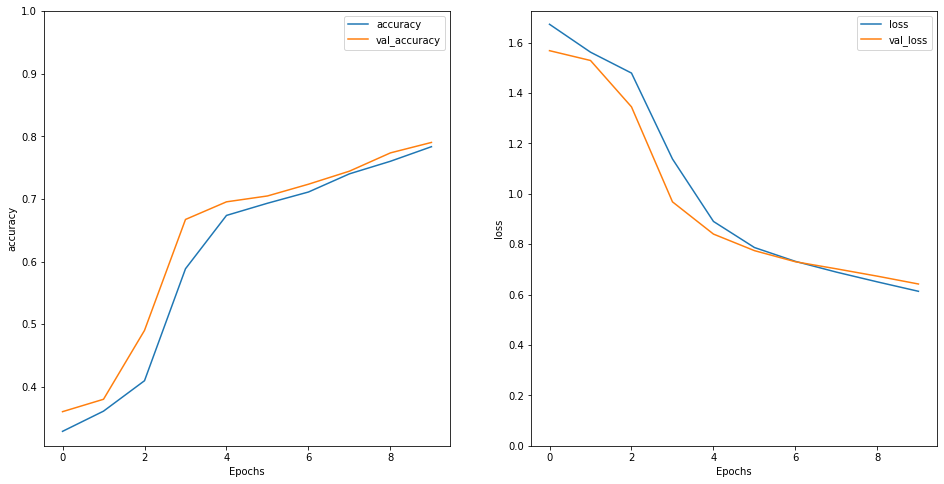

In [17]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)


# 😅
# improve this model...please




In [ ]:
# Arrido was here

In [14]:
optimizers = [tf.keras.optimizers.Adamax()
            , tf.keras.optimizers.Adadelta()
            , tf.keras.optimizers.Adagrad()
            , tf.keras.optimizers.SGD()
            , tf.keras.optimizers.Adam()]

for opt in optimizers:
  model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6) #this is the output layer, since we have 6 emotions we should have 6 as the output number instead of 1
  ])
  model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              optimizer=opt,
              metrics=['accuracy'])
  history = model.fit(train, epochs=10,
                    validation_data=test,
                    validation_steps=30)
  test_loss, test_acc = model.evaluate(test)

  print('Test Loss:', test_loss)
  print('Test Accuracy:', test_acc)

Epoch 1/10
250/250 [==============================] - 35s 110ms/step - loss: 1.5840 - accuracy: 0.3558 - val_loss: 1.4997 - val_accuracy: 0.4141
Epoch 2/10
250/250 [==============================] - 25s 100ms/step - loss: 1.3417 - accuracy: 0.4902 - val_loss: 1.1394 - val_accuracy: 0.5615
Epoch 3/10
250/250 [==============================] - 25s 100ms/step - loss: 0.9754 - accuracy: 0.6406 - val_loss: 0.8374 - val_accuracy: 0.7073
Epoch 4/10
250/250 [==============================] - 25s 101ms/step - loss: 0.7745 - accuracy: 0.7065 - val_loss: 0.7232 - val_accuracy: 0.7453
Epoch 5/10
250/250 [==============================] - 25s 101ms/step - loss: 0.6817 - accuracy: 0.7493 - val_loss: 0.6635 - val_accuracy: 0.7792
Epoch 6/10
250/250 [==============================] - 25s 101ms/step - loss: 0.6174 - accuracy: 0.7779 - val_loss: 0.6152 - val_accuracy: 0.7901
Epoch 7/10
250/250 [==============================] - 25s 100ms/step - loss: 0.5607 - accuracy: 0.8048 - val_loss: 0.5820 - val_ac

In [ ]:
#TODO: learning rate for Adam, play around with layers, # of epoch
#, # of validation steps, optimizing the process (building a pipeline)